# LiveCuvisDataLoader example

In this example a connection to a cubert camera is established and used to capture live images. These images are then processed by a simple unsupervised graph. Later in the example a new measurement is used to extract a sample spectra and train a spectral angle mapper with to find this spectra in newly presented images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cuvis_ai.preprocessor import PCA, NMF
import cv2 as cv
from cuvis_ai.pipeline import Graph
from cuvis_ai.unsupervised import KMeans, GMM
from cuvis_ai.data.LiveCuvisDataLoader import LiveCuvisDataLoader
from cuvis_ai.distance import Euclidean, SpectralAngle, ECS
import cuvis.AcquisitionContext
from IPython.display import clear_output
%matplotlib inline

create LiveCuvisDataLoader and initialize the camera. The initialize function expects the path to the init.bat

In [2]:
live_loader = LiveCuvisDataLoader()
live_loader.initialize('../../test_data/ASR5232501') # path to camera directory

True

record references for acquisition 

In [3]:
live_loader.record_distance()

In [4]:
live_loader.record_dark()

In [5]:
live_loader.record_white()

display the references, note that the distance reference will not be shown 

In [6]:
live_loader.get_references()

{'Dark': <cuvis.Measurement.Measurement at 0x1cab64c11f0>,
 'White': <cuvis.Measurement.Measurement at 0x1cab6bf5a30>}

Acquire new measurement and display one channel of it. Squeezing is nessecary for displaying because the data loader loads as 5D array *[batch_size, number_of_images, height, width, number_of_channels]*

(275, 290, 51)


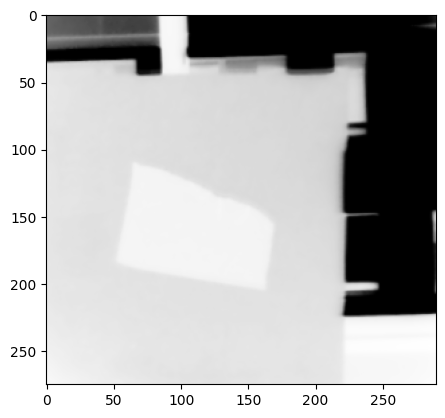

In [34]:
data = live_loader.__next__()
squeezed_data = np.squeeze(data[0])
plt.imshow(squeezed_data[:,:,19], cmap='Greys')


## Graph and Node creation. 
The Graph needs to be fitted to the input data before usage.

In [13]:
graph = Graph("example_graph")
pca_stage = PCA(n_components=5)
kmeans_stage = KMeans(n_clusters=5)
gmm_stage = GMM(n_clusters=3)
graph.add_base_node(pca_stage)
graph.add_node(gmm_stage,pca_stage)
graph.fit(squeezed_data)

## Continuous capturing, processing and displaying of measurements and graph output.

Unfortunately you need to stop the execution manually right now, as matplotlib events and cv.waitKey don't seem to work in jupyter notebooks.

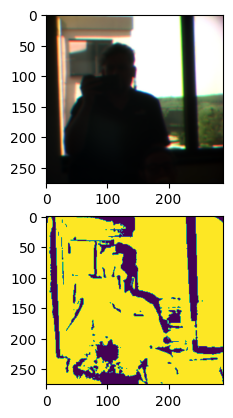

KeyboardInterrupt: 

In [38]:
go_on = True
img = np.zeros((275,290,3))

while go_on:
    cv.startWindowThread()
    clear_output()
    mesu = live_loader.__next__()
    squeezed_mesu = np.squeeze(mesu[0])
    
    out = graph.forward(squeezed_mesu)
    fig, ax = plt.subplots(2)
    
    img[:,:,0] = cv.normalize(squeezed_mesu[:,:,26], None, 1, 0.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    img[:,:,1] = cv.normalize(squeezed_mesu[:,:,9], None, 1, 0.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    img[:,:,2] = cv.normalize(squeezed_mesu[:,:,7], None, 1, 0.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    img[img < 0.001] = 0 
    ax[0].imshow(img)
    ax[1].imshow(out[0])
    plt.show()    
    plt.pause(0.1)


## Extract a Spectrum from center of the image as reference for distance nodes and plot it.

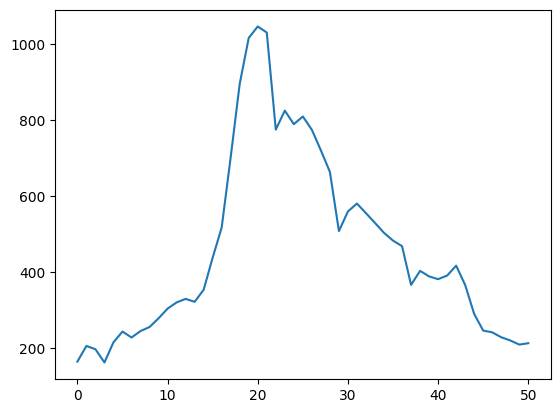

In [35]:
ref_area_size = 20
ref_area_position_y = int(squeezed_data.shape[0]/2)
ref_area_position_x = int(squeezed_data.shape[1]/2)

ref_spectra = np.array([squeezed_data[ref_area_position_y-ref_area_size:ref_area_position_y+ref_area_size, ref_area_position_x-ref_area_size:ref_area_position_x+ref_area_size:, :]])

spectra_mean = np.mean(np.mean(ref_spectra, axis=1), axis=1)

plt.figure()
plt.plot(spectra_mean.T)
plt.show()

## Creation of different distance nodes.

In [36]:
euclidean_node = Euclidean(spectra_mean)
SAM_node = SpectralAngle(spectra_mean)
ECS_node = ECS(spectra_mean)

TypeError: 'ECS' object is not callable

## Using the distance nodes
 
capturing an image, passing it through the distance node and displaying segmentation alongside a channel.

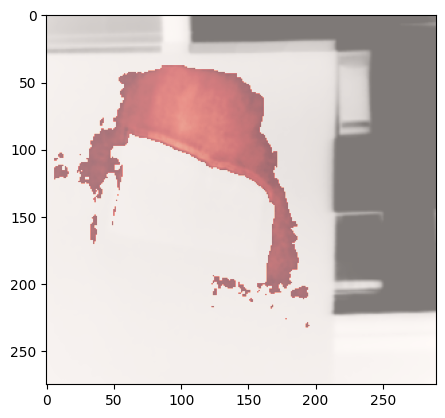

In [37]:
data = live_loader.__next__()
squeezed_data = np.squeeze(data[0])
data_norm = np.linalg.norm(squeezed_data)
data_normed = squeezed_data/data_norm
out = SAM_node.forward(data_normed, spectra_mean)
out[out > out.max()*0.1] = 0
fig = plt.figure()
ax = fig.add_subplot(111)
img = squeezed_data[:,:,31] 
ax.imshow(img,cmap="binary")
ax.imshow(out, cmap="Reds", alpha=0.5)